🧾**Description:**
* The dataset used for predictive modelling was generated by the Wild Blueberry Pollination Simulation Model, which is an open-source, spatially-explicit computer simulation program, that enables exploration of how various factors, including plant spatial arrangement, outcrossing and self-pollination, bee species compositions and weather conditions, in isolation and combination, affect pollination efficiency and yield of the wild blueberry agro-ecosystem.
* The simulation model has been validated by the field observation and experimental data collected in Maine USA and Canadian Maritimes during the last 30 years and now is a useful tool for hypothesis testing and theory development for wild blueberry pollination researches.
* This simulated data provides researchers who have actual data collected from field observation and those who wants to experiment the potential of machine learning algorithms response to real data and computer simulation modelling generated data as input for crop yield prediction models.

* 🧭 **Problem Statement:** The target feature is **yield** which is a continuous variable.
* The task is to classify this variable based on the other 17 features step-by-step by going through each day's task.
* The evaluation metrics will be RMSE score


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [75]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.8 MB/s eta 0:00:00


In [100]:
#basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
sns.set_style('darkgrid')
from sklearn.model_selection import KFold,LeaveOneOut,cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.svm import SVR
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest
from xgboost import XGBRegressor,plot_importance
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error,get_scorer_names
pd.set_option('display.max_columns', None)
import warnings
from yellowbrick.regressor import PredictionError,ResidualsPlot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import f1_score,make_scorer
from sklearn.feature_selection import VarianceThreshold
warnings.filterwarnings('ignore')
import shap
from shap import TreeExplainer,Explainer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# **Look on the Dataset**

In [3]:
#load dataset
df=pd.read_csv("/content/drive/MyDrive/MGP_Project/WildBlueberryPollinationSimulationData.csv")

In [4]:
df.head()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [5]:
df.shape

(777, 18)

# **Data Preparation**

In [6]:
df.columns=df.columns.str.lower()
df.sample(2)

,row#,clonesize,honeybee,bumbles,andrena,osmia,maxofuppertrange,minofuppertrange,averageofuppertrange,maxoflowertrange,minoflowertrange,averageoflowertrange,rainingdays,averagerainingdays,fruitset,fruitmass,seeds,yield
68,68,12.5,0.25,0.25,0.25,0.38,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.587049,0.49282,41.135893,7267.283440
128,128,12.5,0.25,0.25,0.25,0.75,77.4,46.8,64.7,55.8,27.0,45.8,34.0,0.56,0.574989,0.48510,40.171431,7044.567605


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   maxofuppertrange      777 non-null    float64
 7   minofuppertrange      777 non-null    float64
 8   averageofuppertrange  777 non-null    float64
 9   maxoflowertrange      777 non-null    float64
 10  minoflowertrange      777 non-null    float64
 11  averageoflowertrange  777 non-null    float64
 12  rainingdays           777 non-null    float64
 13  averagerainingdays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

* All the features are of int or float datatypes .


# **Train and Test Data Split**

In [8]:
X=df.drop(columns=["yield"],axis=1)
Y=df["yield"]

In [9]:
#80-20 split
x_full_train,x_test,y_full_train,y_test=train_test_split(X,Y,test_size=0.10,random_state=42)
x_train,x_val,y_train,y_val=train_test_split(x_full_train,y_full_train,test_size=0.10,random_state=42)

In [10]:
print("Shape of Training data",x_train.shape)
print("Shape of Validation data",x_val.shape)
print("Shape of Testing data",x_test.shape)

Shape of Training data (629, 17)
Shape of Validation data (70, 17)
Shape of Testing data (78, 17)


# **Data Cleaning**

* Duplicate Check.
* Exploring Basic Statistics.


## **Duplicate Check**

In [11]:
#get the count of duplicates
x_train.duplicated().sum()

0

## **Exploring Basic Statistics**

In [12]:
#get the basic statistics
x_train.describe()

,row#,clonesize,honeybee,bumbles,andrena,osmia,maxofuppertrange,minofuppertrange,averageofuppertrange,maxoflowertrange,minoflowertrange,averageoflowertrange,rainingdays,averagerainingdays,fruitset,fruitmass,seeds
count,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,386.790143,18.720191,0.421598,0.283711,0.468755,0.562851,82.411765,49.773291,68.830684,59.407949,28.735453,48.688076,18.167313,0.317997,0.504250,0.447152,36.244777
std,225.693356,7.032370,1.057040,0.066478,0.162899,0.166183,9.149757,5.575066,7.639384,6.616713,3.193784,5.390975,12.108211,0.170695,0.078069,0.040141,4.363811
min,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.249335,0.320727,23.412776
25%,191.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,1.000000,0.100000,0.453235,0.416802,33.125467
50%,386.000000,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.509158,0.446570,36.262930
75%,587.000000,25.000000,0.500000,0.380000,0.630000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,24.000000,0.390000,0.564904,0.477182,39.448650
max,776.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105


* We know that fruitset, fruit mass, seeds are arrived from yield we will be removing that.

In [13]:
columns=['fruitset','fruitmass','seeds']
x_train.drop(columns=columns,axis=1,inplace=True)
x_test.drop(columns=columns,axis=1,inplace=True)
x_val.drop(columns=columns,axis=1,inplace=True)

In [14]:
#get unique values in each columns.
x_train.nunique()

row#                    629
clonesize                 5
honeybee                  7
bumbles                   8
andrena                  11
osmia                    10
maxofuppertrange          5
minofuppertrange          5
averageofuppertrange      5
maxoflowertrange          5
minoflowertrange          5
averageoflowertrange      5
rainingdays               5
averagerainingdays        5
dtype: int64

* Each row has unique rowID's hence removing that too since it will not be useful for further analysis .



In [15]:
x_train.drop(columns='row#',axis=1,inplace=True)
x_test.drop(columns='row#',axis=1,inplace=True)
x_val.drop(columns='row#',axis=1,inplace=True)

In [16]:
for i in x_train.columns:
    print(f"Unique value in {i}:")
    print(x_train[i].unique(),'\n')

Unique value in clonesize:
[25.  12.5 37.5 20.  40. ] 

Unique value in honeybee:
[ 0.5    0.25   0.75   0.     0.537 18.43   6.64 ] 

Unique value in bumbles:
[0.38  0.25  0.293 0.117 0.585 0.042 0.    0.202] 

Unique value in andrena:
[0.5   0.75  0.25  0.38  0.63  0.234 0.409 0.    0.147 0.707 0.585] 

Unique value in osmia:
[0.75  0.63  0.25  0.38  0.5   0.058 0.    0.021 0.585 0.101] 

Unique value in maxofuppertrange:
[86.  94.6 77.4 69.7 89. ] 

Unique value in minofuppertrange:
[52.  57.2 46.8 42.1 39. ] 

Unique value in averageofuppertrange:
[71.9 79.  64.7 58.2 65.6] 

Unique value in maxoflowertrange:
[62.  68.2 55.8 50.2 66. ] 

Unique value in minoflowertrange:
[30.  33.  27.  24.3 28. ] 

Unique value in averageoflowertrange:
[50.8 55.9 45.8 41.2 45.3] 

Unique value in rainingdays:
[24.   16.   34.    1.    3.77] 

Unique value in averagerainingdays:
[0.39 0.26 0.56 0.1  0.06] 



In [17]:
x_train.head()

,clonesize,honeybee,bumbles,andrena,osmia,maxofuppertrange,minofuppertrange,averageofuppertrange,maxoflowertrange,minoflowertrange,averageoflowertrange,rainingdays,averagerainingdays
733,25.0,0.50,0.38,0.50,0.75,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39
729,25.0,0.50,0.38,0.50,0.75,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26
624,25.0,0.50,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,34.0,0.56
55,12.5,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39
674,25.0,0.50,0.38,0.38,0.63,77.4,46.8,64.7,55.8,27.0,45.8,1.0,0.10


# **Exploratory Data Analysis**
* Target Feature Analysis.
* Univariate Analysis of Numerical Data.
* Multivariate Analysis of Numerical Data.


In [18]:
#combining x and y of training data
data=pd.concat([x_train, y_train], axis=1)

## **Target Feature Analysis**

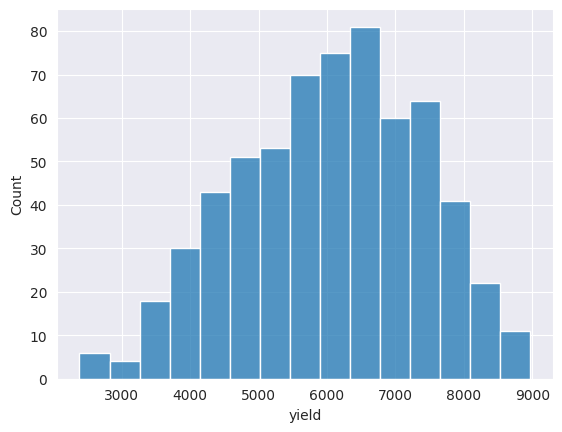

In [19]:
sns.histplot(data=data,x='yield')
plt.show()

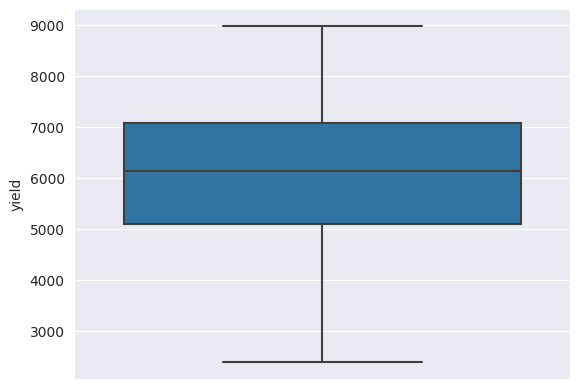

In [20]:
sns.boxplot(data=data,y='yield')
plt.show()

* The yield is centered arround 5000 - 8000 with almost normal distribution and less prone to outlier.

##  **Univariate Numerical Analysis**

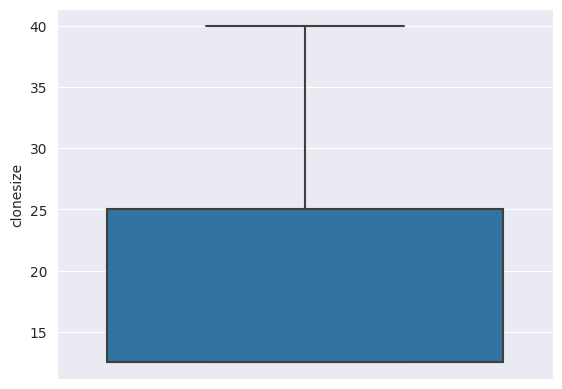

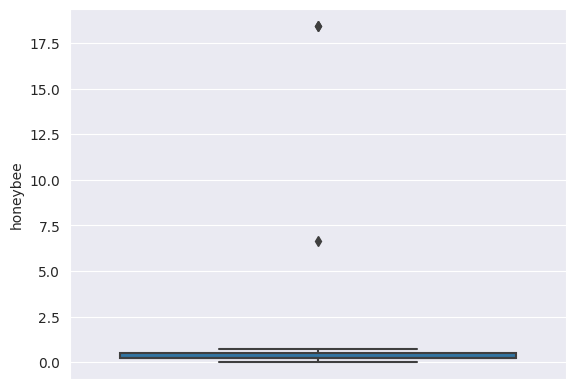

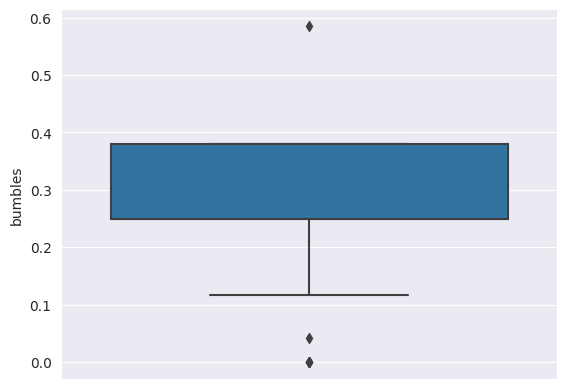

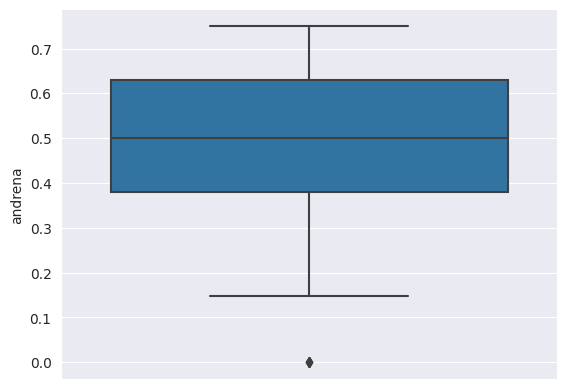

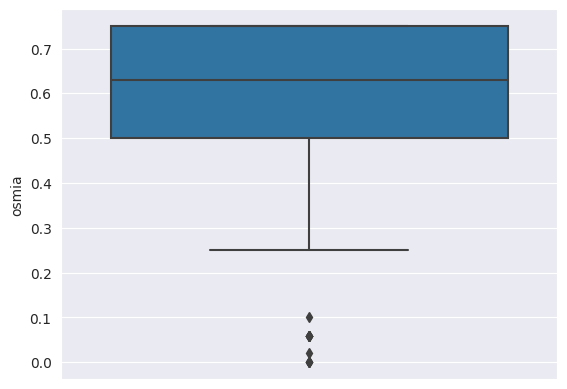

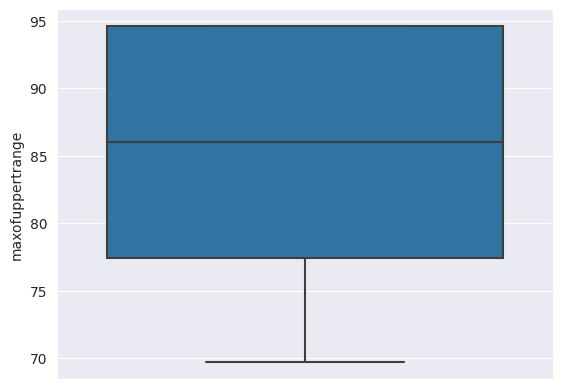

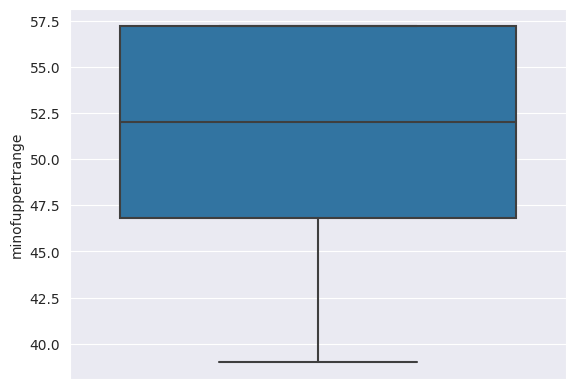

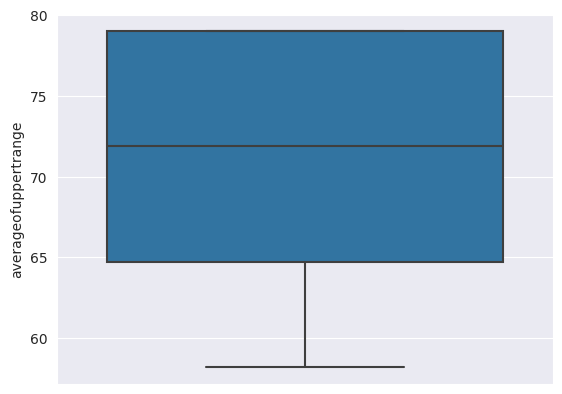

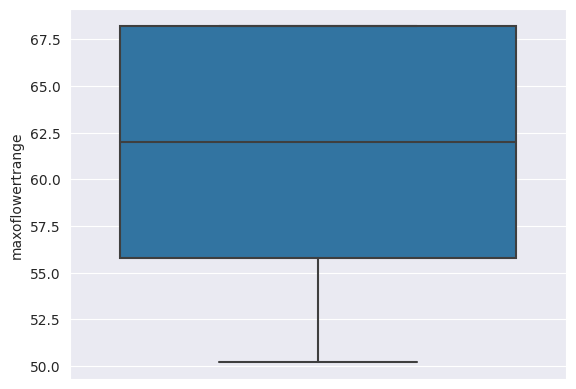

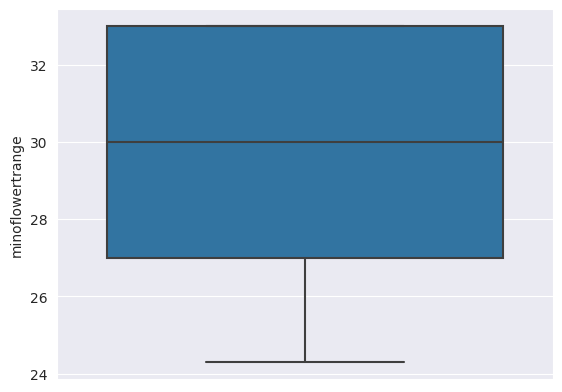

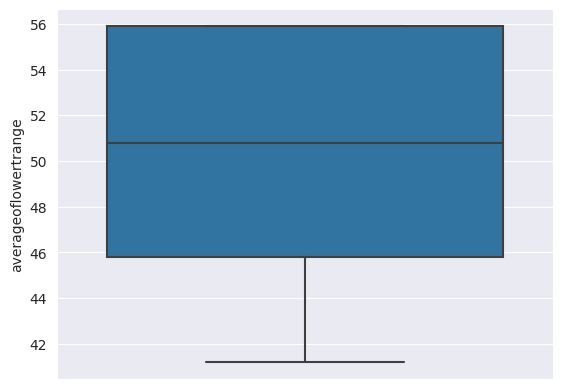

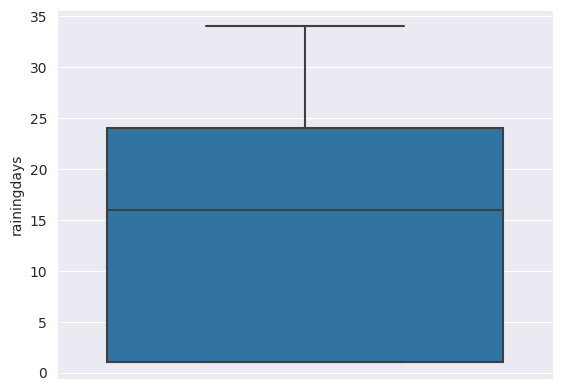

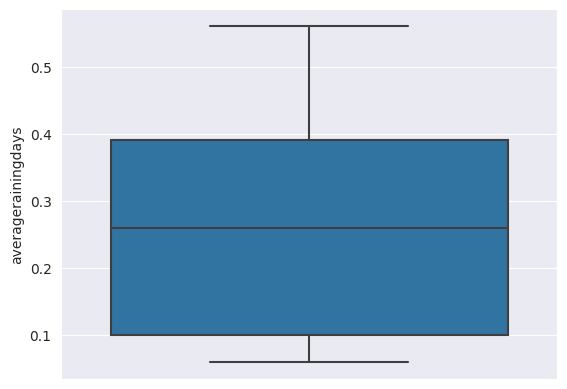

In [21]:
for col in x_train.columns.to_list():
  sns.boxplot(data=data,y=col)
  plt.show()

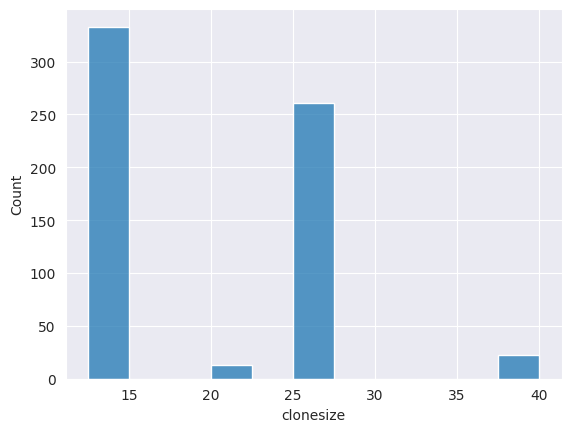

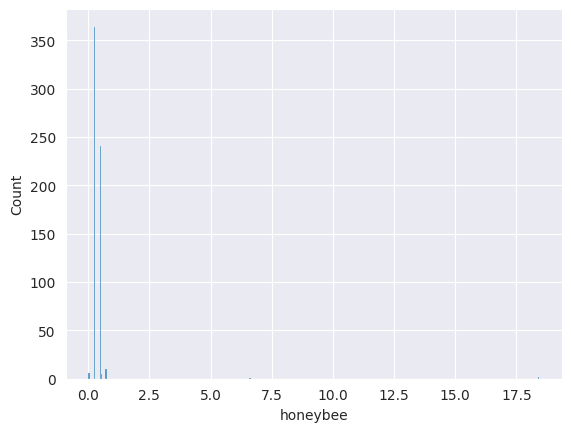

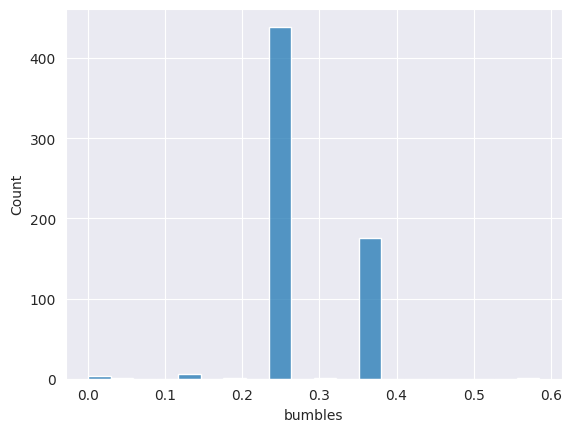

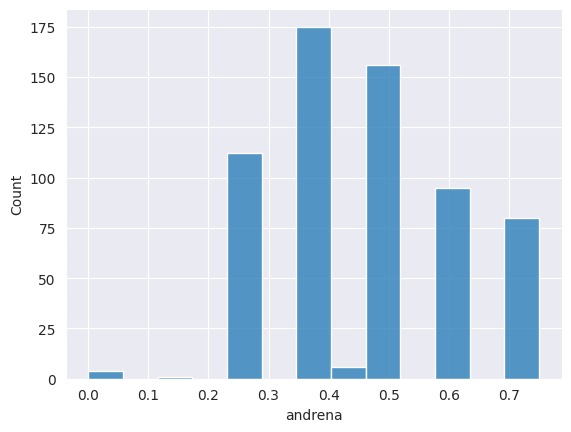

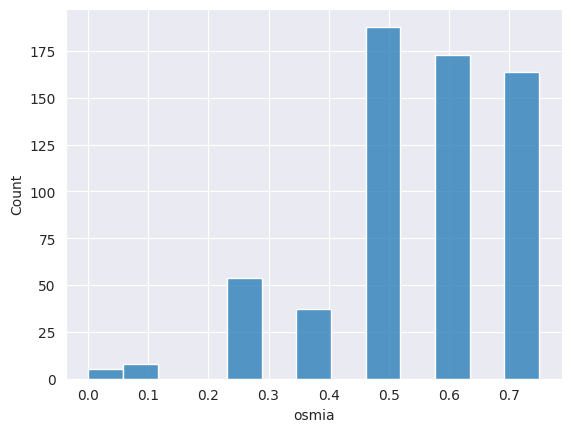

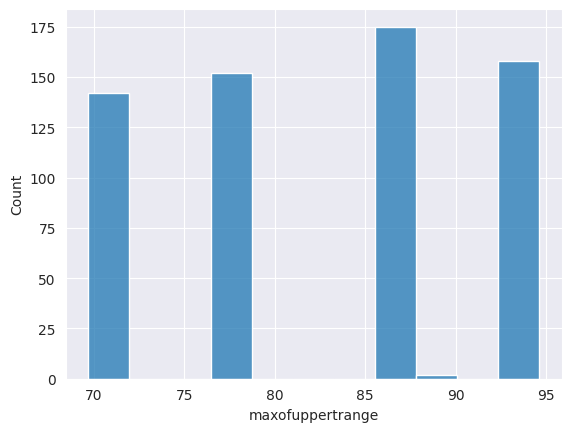

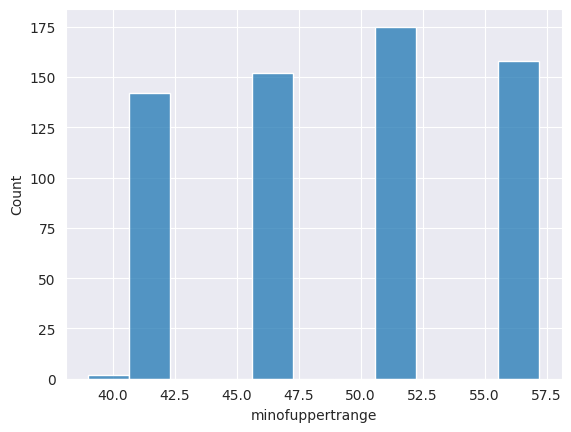

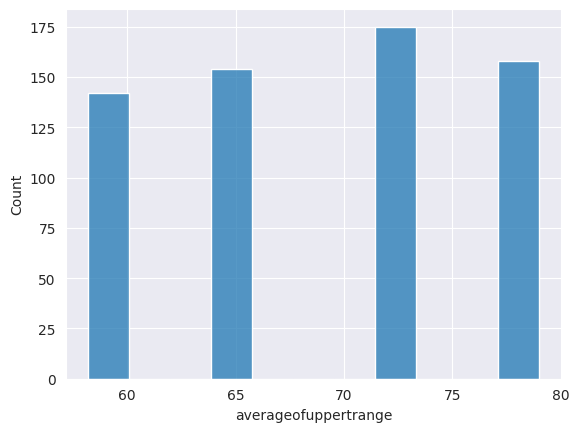

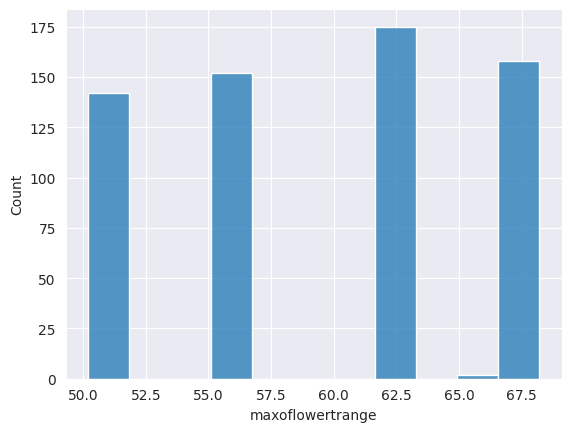

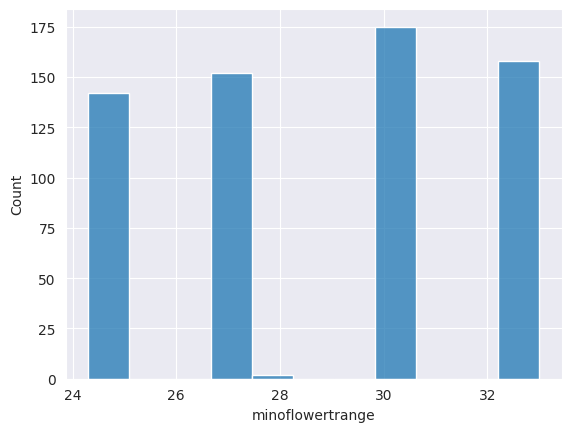

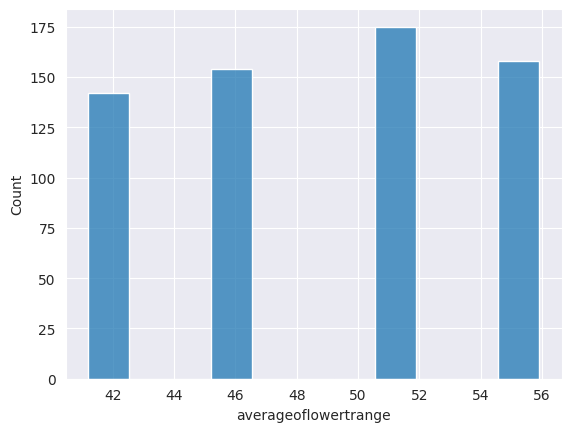

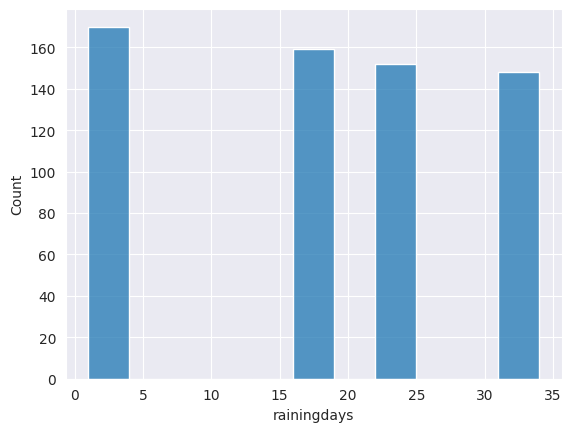

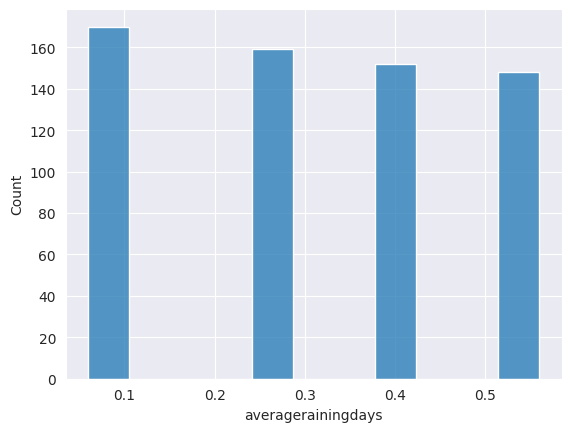

In [22]:
for col in x_train.columns.to_list():
  sns.histplot(data=data,x=col)
  plt.show()

* HoneyBee density  has few outliers .

## **Multivariate Numerical Analysis**

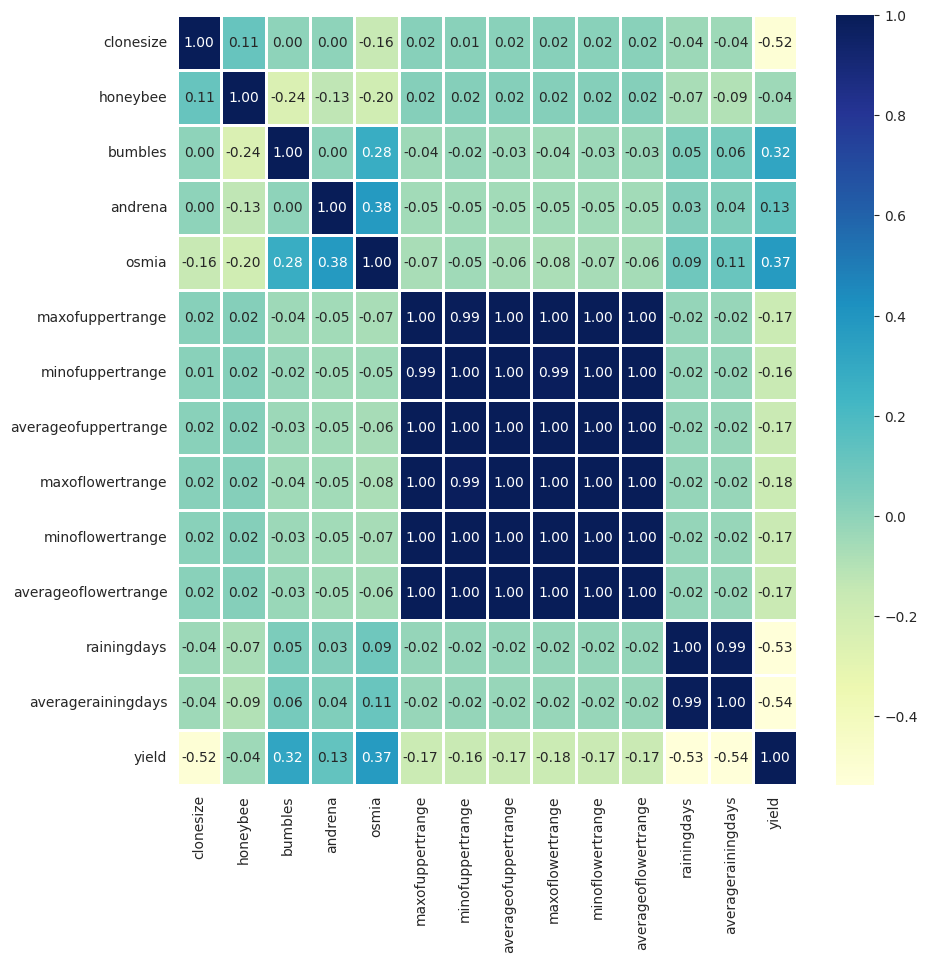

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True,fmt = '.2f',linewidth=1)
plt.show()

* Here some of the features are correlated.

* CloneSize is negatively correlated to yield.
* Bumbles,andrena,osmia are positively correlated to the yield .

# **Preprocessing**

## **Missing Value Treatment**

In [24]:
x_train.isna().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
maxofuppertrange        0
minofuppertrange        0
averageofuppertrange    0
maxoflowertrange        0
minoflowertrange        0
averageoflowertrange    0
rainingdays             0
averagerainingdays      0
dtype: int64

## **Feature Engineering**

In [25]:
def select_features_corr_based(x_train, y_train, x_val, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(x_train, y_train)
    x_train_fs = fs_corr.transform(x_train)
    x_val_fs = fs_corr.transform(x_val)
    return pd.DataFrame(data=x_train_fs,columns=fs_info.get_feature_names_out()), pd.DataFrame(data=x_val_fs,columns=fs_info.get_feature_names_out()), fs_corr

In [26]:
def select_features_infogain_based(x_train, y_train, x_val, x="all"):
    if type(x) == str:
        fs_info = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs_info = SelectKBest(score_func=mutual_info_regression, k=x)
    fs_info.fit(x_train, y_train)
    x_train_fs = fs_info.transform(x_train)
    x_val_fs = fs_info.transform(x_val)
    return pd.DataFrame(data=x_train_fs,columns=fs_info.get_feature_names_out()), pd.DataFrame(data=x_val_fs,columns=fs_info.get_feature_names_out()), fs_info

In [27]:
X_train_fs_info, X_val_fs_info, fs_info = select_features_infogain_based(x_train, y_train, x_val)
X_train_fs_corr, X_val_fs_corr, fs_corr = select_features_corr_based(x_train, y_train, x_val)

Feature clonesize: 228.787434
Feature honeybee: 1.235791
Feature bumbles: 69.935617
Feature andrena: 10.689804
Feature osmia: 101.241992
Feature maxofuppertrange: 19.790637
Feature minofuppertrange: 16.659262
Feature averageofuppertrange: 18.310563
Feature maxoflowertrange: 19.935543
Feature minoflowertrange: 18.709505
Feature averageoflowertrange: 18.149545
Feature rainingdays: 250.347921
Feature averagerainingdays: 253.739216


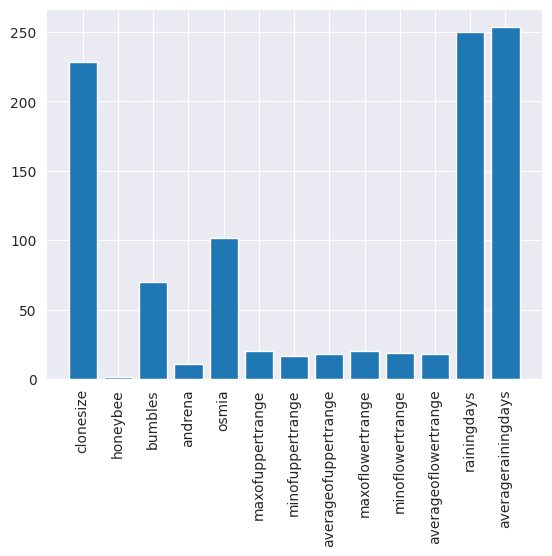

Feature clonesize: 0.175740
Feature honeybee: 0.106437
Feature bumbles: 0.029426
Feature andrena: 0.047391
Feature osmia: 0.092677
Feature maxofuppertrange: 0.109425
Feature minofuppertrange: 0.114432
Feature averageofuppertrange: 0.109103
Feature maxoflowertrange: 0.112485
Feature minoflowertrange: 0.106266
Feature averageoflowertrange: 0.109288
Feature rainingdays: 0.228976
Feature averagerainingdays: 0.231246


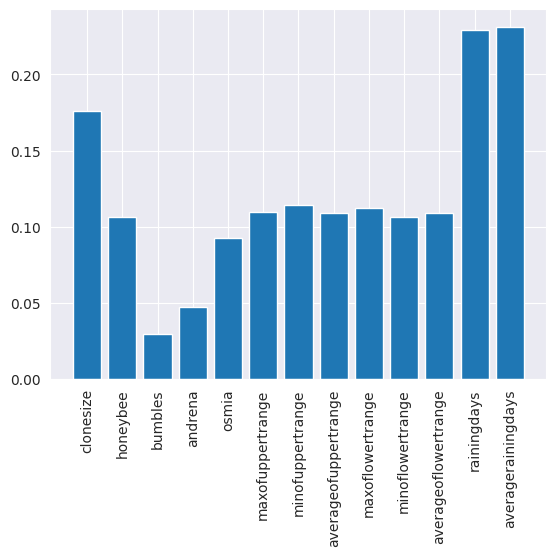

In [28]:
def fs_score_plot(fs_func):

    for i in range(len(fs_func.get_feature_names_out())):
        print('Feature %s: %f' % (fs_func.get_feature_names_out()[i], fs_func.scores_[i]))
    # plot the scores
    plt.bar(fs_func.get_feature_names_out(), fs_func.scores_)
    plt.xticks(rotation=90)
    plt.show()

fs_score_plot(fs_corr)
fs_score_plot(fs_info)

# **Modeling**

* We select mutual info based features for training purpose .

In [29]:
def adj_r2(X, y, r2_score):
  return 1 - ((1-r2_score)*(len(y)-1))/(len(y)-X.shape[1]-1)

## **LinearRegression**

In [30]:
model = Pipeline(steps =[['scaler', RobustScaler()],
                                ['regression', LinearRegression()]])
model.fit(X_train_fs_info,y_train)
print(model.score(X_val_fs_info,y_val))
#run_model(model,pd.concat((X_train_fs_info,X_test_fs_info),axis=0),pd.concat((y_train,y_test),axis=0))

0.8675982971269118


## **Decision Tree for Regression**

In [31]:
dts=DecisionTreeRegressor(random_state=11)
dts.fit(X_train_fs_info,y_train)
print(dts.score(X_val_fs_info,y_val))

0.892091888824418


## **RandomForestRegressor**

In [32]:
rft=RandomForestRegressor(random_state=42)
rft.fit(X_train_fs_info,y_train)
print(rft.score(X_val_fs_info,y_val))

0.8920447521927668


## **XGBoostRegressor**

In [33]:
xbr=XGBRegressor(random_state=42)
xbr.fit(X_train_fs_info,y_train)
print(xbr.score(X_val_fs_info,y_val))

0.9067850408650865


['clonesize', 0.35987854]
['rainingdays', 0.25543517]
['osmia', 0.12610285]
['maxofuppertrange', 0.11714084]
['bumbles', 0.10329981]
['andrena', 0.016267056]
['averagerainingdays', 0.011128858]
['honeybee', 0.009940449]
['minofuppertrange', 0.0008065142]
['averageoflowertrange', 0.0]
['minoflowertrange', 0.0]
['maxoflowertrange', 0.0]
['averageofuppertrange', 0.0]


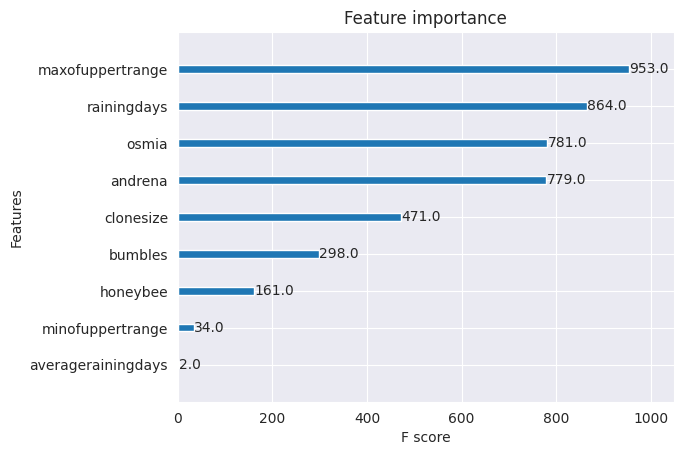

In [34]:
sorted_idx = np.argsort(xbr.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_train_fs_info.columns[index], xbr.feature_importances_[index]])

plot_importance(xbr, max_num_features = 15)
plt.show()

##**RidgeRegression**

In [35]:
model = Pipeline(steps = [['scaler', RobustScaler()],
                                ['regression', Ridge()]])
model.fit(X_train_fs_info,y_train)
print(model.score(X_val_fs_info,y_val))

0.8092314505546543


## **LassoRegresssion**

In [36]:
model = Pipeline(steps = [['scaler', RobustScaler()],
                                ['regression', Lasso()]])
model.fit(X_train_fs_info,y_train)
print(model.score(X_val_fs_info,y_val))

0.8083962157150258


* We can see that Linear Models are performing far better than tree based models .

## **Elastic Net Regression**

In [37]:
model = Pipeline(steps = [['scaler', RobustScaler()],
                                ['regression', ElasticNet()]])
model.fit(X_train_fs_info,y_train)
print(model.score(X_val_fs_info,y_val))

0.5935699861282162


# **HyperParameter Tuning**

## **Tune Degree parameters**

* We will tune with polynomial Features for Linear Models and check r2 value in validation dataset .

In [38]:
def find_degree(X,y):
 # Performing k-fold cross validation
 degrees = 3 # number of degrees
 train_scores = []
 val_scores = []
 kf = KFold(n_splits=5)
 for degree in range(1, degrees):
    fold_train_scores = []
    fold_val_scores = []

    for train_index, val_index in kf.split(X): #iterating through the K-folds

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        polyreg_scaled = make_pipeline(PolynomialFeatures(degree,interaction_only=False,include_bias=False), RobustScaler(), LinearRegression())
        polyreg_scaled.fit(X_train, y_train) #training model

        train_score = adj_r2(X_train, y_train, polyreg_scaled.score(X_train, y_train))
        val_score= adj_r2(X_val, y_val, polyreg_scaled.score(X_val, y_val))

        fold_train_scores.append(train_score)
        fold_val_scores.append(val_score)

    train_score = np.mean(fold_train_scores)
    val_score = np.mean(fold_val_scores)

    train_scores.append(train_score)
    val_scores.append(val_score)
 plt.figure()
 plt.plot(list(range(1,3)), train_scores, label="train")
 plt.plot(list(range(1, 3)), val_scores, label="val")
 plt.legend(loc='lower right')
 plt.xlabel("degree")
 plt.ylabel("Average R2 score")
 plt.show()

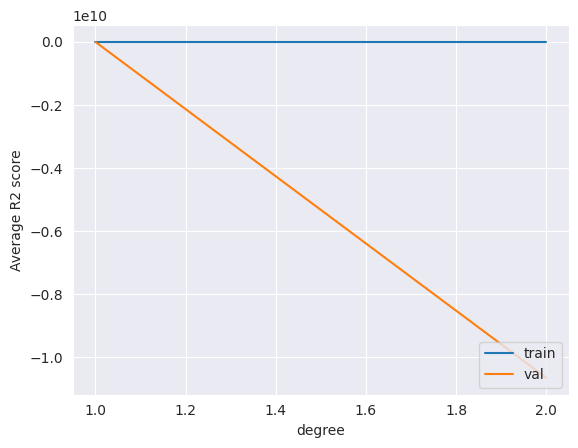

In [39]:
find_degree(X_train_fs_info,y_train)

* Degree 1 is working fine in case of linear Regression so we wont alter the degrees .

## **RandomSearch for XGBoost**##

In [42]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0,1.2,1.5],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6,7,8],
        'n_estimators':[100,200,300,400,500,600,700]
        }

In [43]:
xgb = XGBRegressor(learning_rate=0.02,
                    silent=True)

In [44]:
folds = 3
param_comb = 5

skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='r2', n_jobs=-1, cv=skf.split(X_train_fs_info,y_train), verbose=3, random_state=1001 )

In [45]:
random_search.fit(X_train_fs_info,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7eb87cc22dc0>,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700],
                                        'subsample': [0.6, 0.8, 1.0, 1.2, 1.5]},
                   random_state=1001, scoring='r2', verbose=3)

In [46]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)



 All results:
{'mean_fit_time': array([0.0154206 , 0.12318198, 0.21574148, 0.54622491, 0.02131859]), 'std_fit_time': array([0.00150238, 0.01031684, 0.01143123, 0.06158115, 0.00076871]), 'mean_score_time': array([0.        , 0.00835498, 0.0090584 , 0.01660649, 0.        ]), 'std_score_time': array([0.        , 0.00098661, 0.00048956, 0.00704701, 0.        ]), 'param_subsample': masked_array(data=[1.2, 0.8, 1.0, 0.6, 1.5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[300, 200, 400, 700, 700],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 10, 1, 1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[7, 5, 5, 7, 3],
             mask=[False, False, False, False, False],
       fill_value='?'

#**Error Plot**

In [63]:
params={'subsample': 0.6, 'n_estimators': 700, 'min_child_weight': 1, 'max_depth': 7, 'gamma': 5, 'colsample_bytree': 0.8}
xgb = XGBRegressor(learning_rate=0.02,
                    **params)

In [67]:
best_param_model = xgb

In [68]:
x_final_test=pd.concat((x_val,x_test))
y_final_test=pd.concat((y_val,y_test))

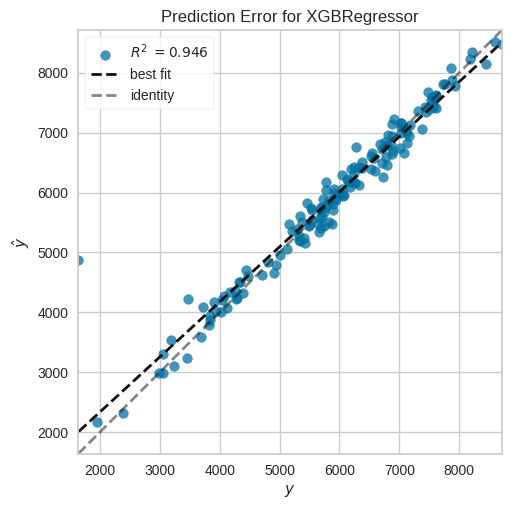

In [69]:
visualizer = PredictionError(best_param_model)
visualizer.fit(X_train_fs_info, y_train)
visualizer.score(x_final_test, y_final_test)
visualizer.show()
plt.show()

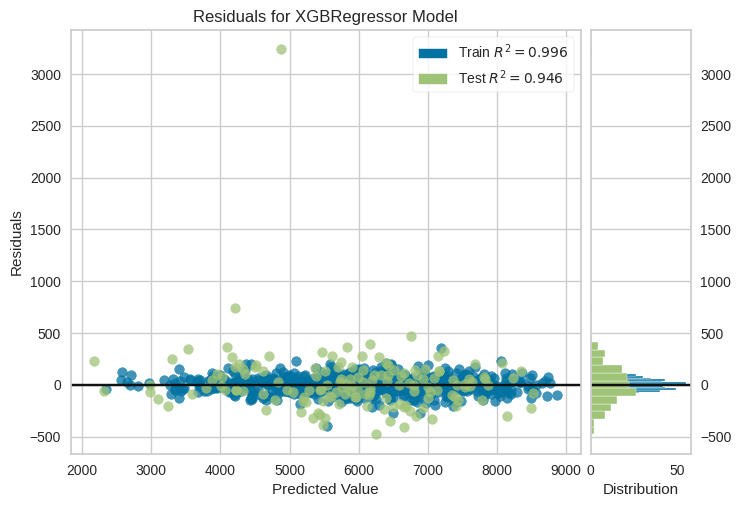

In [71]:
visualizer = ResidualsPlot(best_param_model)
visualizer.fit(X_train_fs_info, y_train)
visualizer.score(x_final_test, y_final_test)
visualizer.show()
plt.show()

#**Explainable AI**

In [72]:
xbr_pred=best_param_model.predict(x_final_test)
print(mean_absolute_error(y_final_test, xbr_pred))
print(np.sqrt(mean_squared_error(y_final_test, xbr_pred)))

168.0356217303632
326.1498209231019


In [81]:
shap_values = Explainer(best_param_model).shap_values(x_final_test)
shap_interaction_values = Explainer(best_param_model).shap_interaction_values(x_final_test)

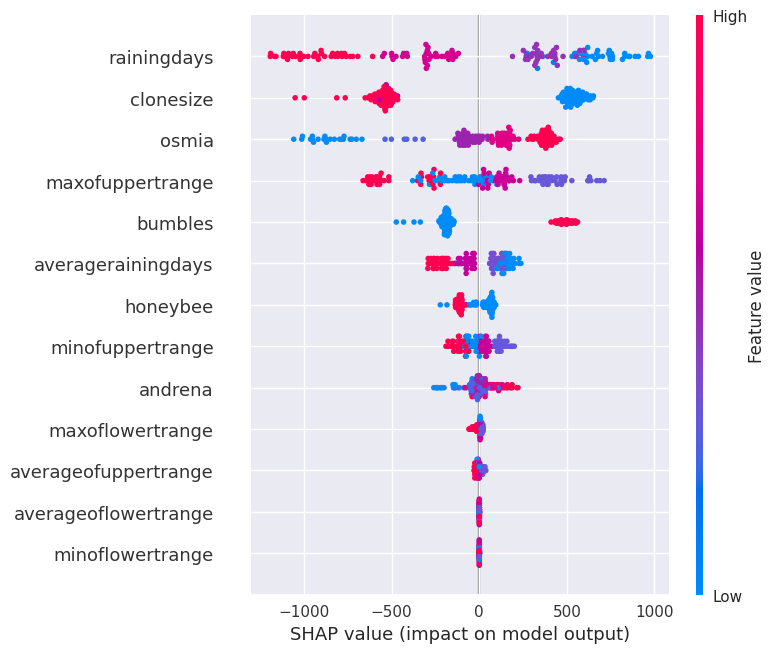

In [86]:
shap.summary_plot(shap_values, x_final_test)

* Higher value of raining days lowers the predicted values and vice versa
* Average of lowertrange,average of upper trange,max of lower trange,minoflowertrange have no impact on the prediction.

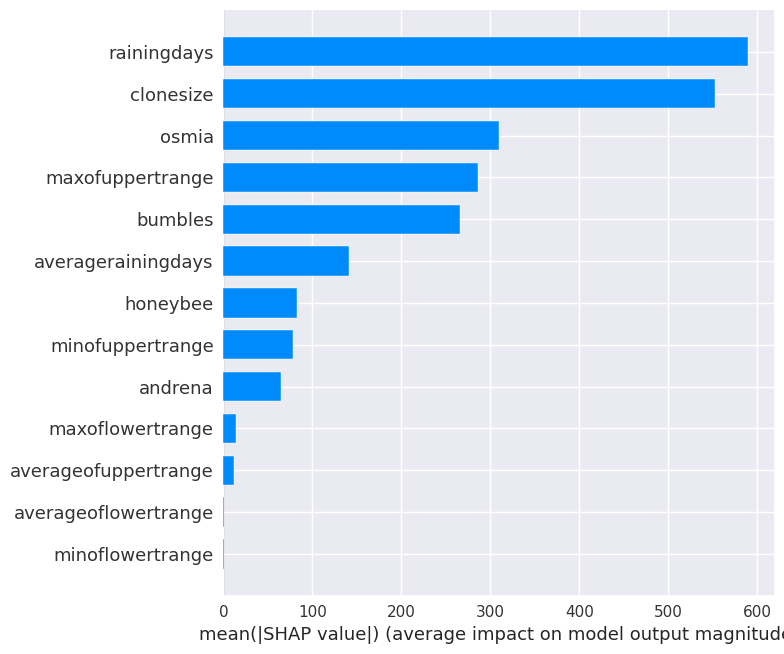

In [92]:
shap.summary_plot(shap_values, x_final_test,plot_type="bar")

In [88]:
shap.initjs()
shap.force_plot(Explainer(best_param_model).expected_value, shap_values[50], x_final_test.iloc[50])

* Raining days and Clonesize contributes positively for the prediction while maxofuppertrange contributed towardsnegative side of it.

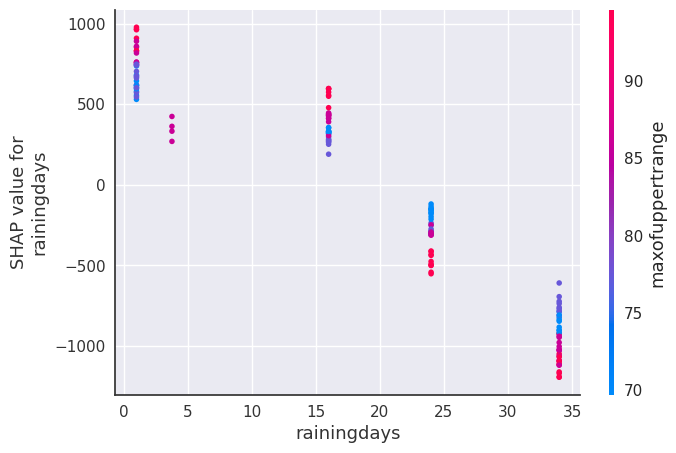

In [94]:
shap.dependence_plot("rainingdays", shap_values, x_final_test)

* Lower value of raining days have positive impact on model prediction and vice versa.

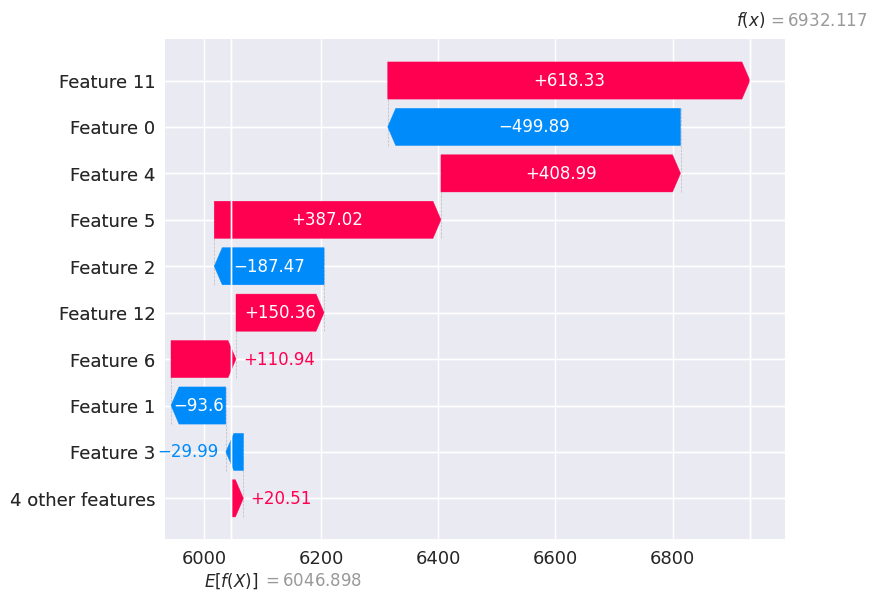

In [98]:
row = 110
shap.plots._waterfall.waterfall_legacy(Explainer(best_param_model).expected_value[0], shap_values[row])

In [97]:
x_final_test.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'maxofuppertrange', 'minofuppertrange', 'averageofuppertrange',
       'maxoflowertrange', 'minoflowertrange', 'averageoflowertrange',
       'rainingdays', 'averagerainingdays'],
      dtype='object')

* Raining days and osmia contibuted postively more for prediction and clonesize contributed negatively for the prediction.

# **Saving best model**

In [101]:
joblib.dump(best_param_model, "best_param_model.joblib", compress=1)

['best_param_model.joblib']